In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
tic = pd.read_csv("TIC82_notnull_tic_kic.csv")

In [3]:
prot_mcq = pd.read_csv("prot_mcq.dat",sep="\s+")

In [4]:
tic_mcq = pd.merge(prot_mcq, tic, how='inner', on='KIC')

In [5]:
tic_mcq

,KOI,KIC,Teff_x,log(g),Rad_x,POrb,PRot,e_PRot,RVar,TIC,...,Bmag,Clist,e_Bmag,e_Kmag,e_Vmag,ID,Kmag,m_TIC,q_2MASS,Vmag
0,3,10748390,4766,4.59,4.68,4.888,29.472,0.134,11.75,28230919,...,10.556,NaN,0.141,0.020,0.030,347873767,7.009,NaN,AAA-111-111-000-0-0,9.460
1,12,5812701,6419,4.26,13.40,17.855,1.245,0.124,0.78,169461816,...,11.731,NaN,0.173,0.018,0.014,344977669,10.234,NaN,AAA-222-111-000-0-0,11.510
2,41,6521045,5909,4.28,1.24,6.887,24.988,2.192,0.39,159654016,...,11.857,NaN,0.149,0.014,0.011,282602173,9.768,NaN,AAA-222-111-000-0-0,11.055
3,42,8866102,6170,4.10,2.71,17.834,20.850,0.007,1.12,164458714,...,9.952,NaN,0.046,0.013,0.003,223708403,8.140,NaN,AAA-112-111-000-0-0,9.495
4,44,8845026,6250,3.50,9.61,66.468,3.792,0.907,1.16,239276046,...,14.236,NaN,0.048,0.022,0.103,369464831,11.664,NaN,AAA-222-111-000-0-0,13.505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,3141,5440317,5348,4.53,1.10,2.319,NaN,NaN,NaN,121946404,...,15.665,NaN,0.037,0.041,0.217,265761442,13.136,NaN,UAA-622-033-0cc-0-0,14.983
2005,3142,3752110,6279,4.66,2.30,27.944,NaN,NaN,NaN,137765338,...,15.450,NaN,0.066,0.055,0.160,296837415,13.951,NaN,AAA-222-111-000-0-0,15.466
2006,3145,1717722,4638,4.72,0.87,0.977,NaN,NaN,NaN,122515768,...,14.906,NaN,0.065,0.039,0.126,276528755,13.358,NaN,AAA-222-222-ccc-0-0,16.047
2007,3146,10908248,5664,4.35,1.41,39.858,NaN,NaN,NaN,279917282,...,14.762,NaN,0.067,0.025,0.183,235210923,12.561,NaN,AAA-222-111-000-0-0,14.240


In [6]:
# wright et al 2018 (eqn 5): valid for range 1.1 < V-K < 7.0
def taucVK(V,K):
    if np.fabs(V - K - 4.05) <= 2.95:
        return pow(10.,0.64 + 0.25 * (V - K))
    else:
        return np.nan

def RoVK(Prot, V, K):
    return Prot / taucVK(V,K)
    
    
# wright et al 2018 (eqn 6): valid for range 0.08 < M/Msol < 1.36
#M in solar masses
def taucM(M):
    if np.fabs(M - 0.72) <= 0.64:
        return pow(10., 2.33 - 1.50 * M + 0.31 * pow(M, 2.))
    else:
        return np.nan
    
def RoM(Prot, M):
    return Prot / taucM(M)

def RoAvg(RoVK, RoM):
    if not np.isnan(RoVK) and not np.isnan(RoM):
        return (RoVK + RoM) / 2.
    elif np.isnan(RoVK) and not np.isnan(RoM):
        return RoM
    elif not np.isnan(RoVK) and np.isnan(RoM):
        return RoVK
    else:
        return np.nan

In [7]:
tic_mcq['RoVK'] = tic_mcq.apply(lambda x: RoVK(x['PRot'], x['Vmag'], x['Kmag']), axis=1)
tic_mcq['TaucVK'] = tic_mcq.apply(lambda x: taucVK(x['Vmag'], x['Kmag']), axis=1)
tic_mcq['RoM'] = tic_mcq.apply(lambda x: RoM(x['PRot'], x['Mass']), axis=1)
tic_mcq['TaucM'] = tic_mcq.apply(lambda x: taucM(x['Mass']), axis=1)

In [8]:
t_eu = pd.read_csv('exoplanet.eu_catalog.csv')

In [9]:
re_kic = re.compile(r"^\s*(KIC\s(\d+))")
re_koi = re.compile(r"^\s*(KOI-(\d+))")
def alt_name_cols(row):
    
    new_row = row.copy(deep=False)
    
    new_row['KIC'] = np.nan
    new_row['KOI'] = np.nan
    
    s_name = str(row['star_name'])
    
    m_kic = re.search(re_kic, s_name)
    if m_kic is not None:
        new_row['KIC'] = int(m_kic.group(2))
            
    m_koi = re.search(re_koi, s_name)
    if m_koi is not None:
        new_row['KOI'] = int(m_koi.group(2))
    
    
    s_alt_names_str = str(row['star_alternate_names'])
    s_alt_name_list = s_alt_names_str.split(",")
    
    for s_alt_name in reversed(s_alt_name_list):
        m_kic = re.search(re_kic, s_alt_name)
        if m_kic is not None:
            new_row['KIC'] = int(m_kic.group(2))
            continue
        
        m_koi = re.search(re_koi, s_alt_name)
        if m_koi is not None:
            new_row['KOI'] = int(m_koi.group(2))
            continue
            
    return new_row

In [10]:
kep_eu = t_eu.apply(alt_name_cols, axis=1)
kep_eu.fillna(np.nan)
kep_eu = kep_eu[(np.isfinite(kep_eu['KIC'])) | (np.isfinite(kep_eu['KOI']))]

In [11]:
tic_mcq_eu = pd.merge(tic_mcq, kep_eu, how='inner', on='KIC')
# tic_mcq_eu
len(tic_mcq_eu)

2092

In [12]:
habitable = pd.read_csv("habitable.txt")

In [13]:
habitable_eu = pd.merge(habitable, t_eu, on="# name")
# habitable_eu

In [14]:
set(habitable['# name']) - set(habitable_eu['# name'])

{'K2-332 b'}

In [15]:
tempnames = list(habitable['# name'])
def checknames(s):
    for name in tempnames:
        if name[:-2] in s:
            return True
    return False
habitable_eu2 = tic_mcq_eu[tic_mcq_eu.apply(lambda x: checknames(str(x['star_alternate_names'])), axis=1)]
tic_mcq_eu_addl = tic_mcq_eu.iloc[list(habitable_eu2['semi_major_axis'].notnull().index)]
# tic_mcq_eu_addl

In [16]:
# tic_mcq_eu = pd.merge(tic_mcq_eu, tic_mcq_eu_addl, how='left', on='# name')

In [34]:
data = tic_mcq_eu[(tic_mcq_eu['RoVK'].notnull() | tic_mcq_eu['RoM'].notnull()) & tic_mcq_eu['semi_major_axis'].notnull()][['# name', 'RoVK', 'RoM', 'semi_major_axis', 'Rad_y', 'mass', 'radius']]
data.fillna(np.nan)
data['RoAvg'] = data.apply(lambda x: RoAvg(x['RoVK'], x['RoM']), axis=1)
data

,# name,RoVK,RoM,semi_major_axis,Rad_y,mass,radius,RoAvg
0,KOI-12 b,0.136826,NaN,0.1540,1.491,1.10000,1.230,0.136826
1,Kepler-448 c,0.136826,NaN,4.2000,1.491,22.00000,NaN,0.136826
5,Kepler-410 A b,2.189556,2.349559,0.1226,1.427,NaN,0.253,2.269558
7,Kepler-63 b,0.386551,0.363810,0.0800,0.938,0.37800,0.545,0.375180
8,Kepler-102 b,1.271084,1.190749,0.0550,0.733,0.01353,0.042,1.230917
...,...,...,...,...,...,...,...,...
759,Kepler-1688 b,0.717282,NaN,0.0608,NaN,NaN,0.113,0.717282
764,Kepler-1690 b,1.699201,1.481081,0.7143,0.862,NaN,0.251,1.590141
766,Kepler-404 b,1.661608,1.408136,0.1020,0.792,NaN,0.113,1.534872
767,Kepler-404 c,1.661608,1.408136,0.1180,0.792,NaN,0.153,1.534872


In [35]:
np.max(data['RoAvg'])

2.5061673352610456

In [36]:
habitable_ro = pd.merge(habitable, data)
habitable_ro

,# name,RoVK,RoM,semi_major_axis,Rad_y,mass,radius,RoAvg
0,Kepler-155 c,1.189237,0.937598,0.242,0.772,NaN,0.200,1.063418
1,Kepler-186 f,1.031238,0.850562,0.432,0.548,NaN,0.104,0.940900
2,Kepler-283 c,0.708000,0.614618,0.341,0.631,NaN,0.162,0.661309
3,Kepler-296 e,0.941482,NaN,0.169,NaN,NaN,0.136,0.941482
4,Kepler-296 f,0.941482,NaN,0.255,NaN,NaN,0.161,0.941482


In [37]:
x = np.linspace(0.,2.7,1000) # ro/ro sol x vals
prot_sol = 27.
ro_sol = 1.85
ra_sol = 0.1
r_sol = 1/200.
# all values scaled to solar values at maximum
# combining eqns: (7) Farrish 2019 and (2) Farrish 2021
def ra_schrijver(ro, rad):
    return pow(ro / ro_sol, -1.5 * -0.16) * pow(rad / r_sol, -2 * -0.16)

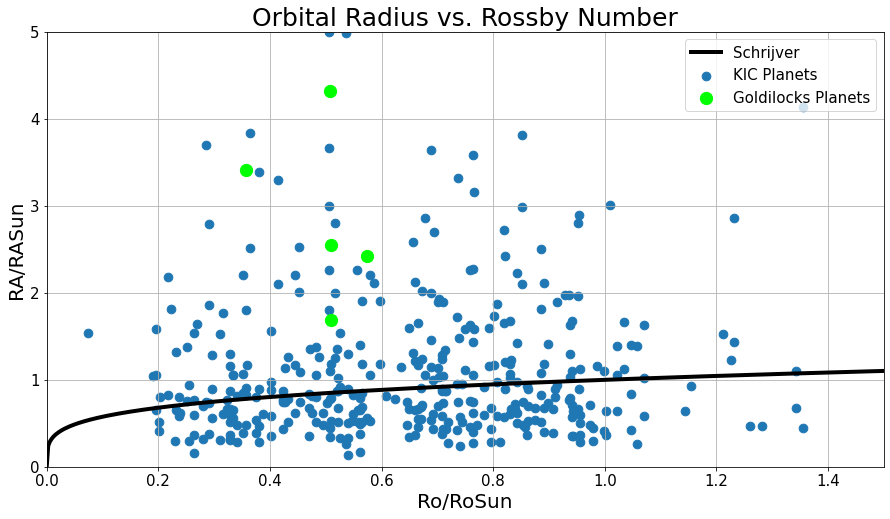

In [38]:
fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(111)
ax1.plot(x, ra_schrijver(x * ro_sol, r_sol), color='black', label='Schrijver', linewidth=4)
ax1.scatter(data['RoAvg'] / ro_sol, data['semi_major_axis'] / ra_sol, s=75, label="KIC Planets")
ax1.scatter(habitable_ro['RoAvg'] / ro_sol, habitable_ro['semi_major_axis'] / ra_sol, color='#00FF00', s=150, label="Goldilocks Planets")
ax1.set_title("Orbital Radius vs. Rossby Number",fontsize=25)
ax1.set_xlabel("Ro/RoSun",fontsize=20)
ax1.set_ylabel("RA/RASun",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax1.grid(visible=True)
ax1.set_xlim([0.0,1.5])
ax1.set_ylim([0.0,5.])
ax1.legend(loc=1,fontsize=15)
pass

In [39]:
data

,# name,RoVK,RoM,semi_major_axis,Rad_y,mass,radius,RoAvg
0,KOI-12 b,0.136826,NaN,0.1540,1.491,1.10000,1.230,0.136826
1,Kepler-448 c,0.136826,NaN,4.2000,1.491,22.00000,NaN,0.136826
5,Kepler-410 A b,2.189556,2.349559,0.1226,1.427,NaN,0.253,2.269558
7,Kepler-63 b,0.386551,0.363810,0.0800,0.938,0.37800,0.545,0.375180
8,Kepler-102 b,1.271084,1.190749,0.0550,0.733,0.01353,0.042,1.230917
...,...,...,...,...,...,...,...,...
759,Kepler-1688 b,0.717282,NaN,0.0608,NaN,NaN,0.113,0.717282
764,Kepler-1690 b,1.699201,1.481081,0.7143,0.862,NaN,0.251,1.590141
766,Kepler-404 b,1.661608,1.408136,0.1020,0.792,NaN,0.113,1.534872
767,Kepler-404 c,1.661608,1.408136,0.1180,0.792,NaN,0.153,1.534872


In [40]:
alfven = data.apply(lambda x: x['semi_major_axis'] / (ra_sol * ra_schrijver(x['RoAvg'], x['Rad_y'])), axis=1)
alfven_data = data.copy(deep=False)
alfven_data['orbit-alfven'] = alfven
alfven_data = alfven_data[alfven_data['Rad_y'].notnull()]
alfven_data

,# name,RoVK,RoM,semi_major_axis,Rad_y,mass,radius,RoAvg,orbit-alfven
0,KOI-12 b,0.136826,NaN,0.1540,1.491,1.10000,1.230,0.136826,0.464642
1,Kepler-448 c,0.136826,NaN,4.2000,1.491,22.00000,NaN,0.136826,12.672066
5,Kepler-410 A b,2.189556,2.349559,0.1226,1.427,NaN,0.253,2.269558,0.191179
7,Kepler-63 b,0.386551,0.363810,0.0800,0.938,0.37800,0.545,0.375180,0.219765
8,Kepler-102 b,1.271084,1.190749,0.0550,0.733,0.01353,0.042,1.230917,0.122932
...,...,...,...,...,...,...,...,...,...
758,Kepler-402 e,0.984033,0.945931,0.1020,1.087,NaN,0.130,0.964982,0.213066
764,Kepler-1690 b,1.699201,1.481081,0.7143,0.862,NaN,0.251,1.590141,1.425494
766,Kepler-404 b,1.661608,1.408136,0.1020,0.792,NaN,0.113,1.534872,0.210932
767,Kepler-404 c,1.661608,1.408136,0.1180,0.792,NaN,0.153,1.534872,0.244019


In [41]:
alfven_habitable = pd.merge(habitable, alfven_data, on='# name')
alfven_habitable

,# name,RoVK,RoM,semi_major_axis,Rad_y,mass,radius,RoAvg,orbit-alfven
0,Kepler-155 c,1.189237,0.937598,0.242,0.772,NaN,0.200,1.063418,0.551011
1,Kepler-186 f,1.031238,0.850562,0.432,0.548,NaN,0.104,0.940900,1.130356
2,Kepler-283 c,0.708000,0.614618,0.341,0.631,NaN,0.162,0.661309,0.928196


In [42]:
alfven_bad = alfven_data[alfven_data['orbit-alfven'] < 0.8]
alfven_maybe = alfven_data[(alfven_data['orbit-alfven'] > 0.8) & (alfven_data['orbit-alfven'] < 1.2)]
alfven_good = alfven_data[alfven_data['orbit-alfven'] > 1.2]
print([len(alfven_bad),len(alfven_maybe),len(alfven_good)])

[347, 9, 9]


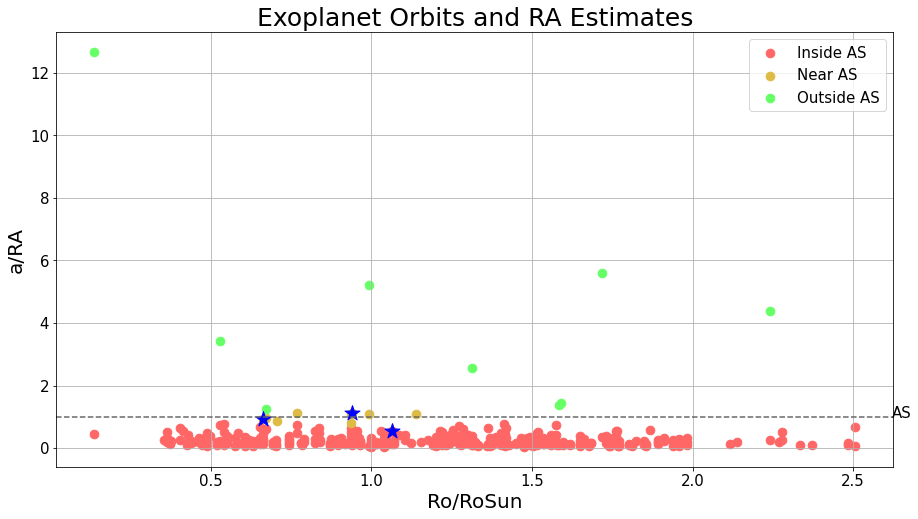

In [76]:
fig2 = plt.figure(figsize=(15,8))
ax2 = fig2.add_subplot(111)
ax2.scatter(alfven_bad['RoAvg'],alfven_bad['orbit-alfven'], color='#FF6666', s=75, label='Inside AS')
ax2.scatter(alfven_maybe['RoAvg'],alfven_maybe['orbit-alfven'], color='#DDBB44', s=75, label='Near AS')
ax2.scatter(alfven_good['RoAvg'],alfven_good['orbit-alfven'], color='#66FF66', s=75, label='Outside AS')
for idx, row in alfven_habitable.iterrows():
    xpt = row['RoAvg']
    ypt = row['orbit-alfven']
    lbl = row['# name']
    ax2.scatter(xpt, ypt, color='#0000FF', s=250, marker='*')
#     ax2.text(xpt + 0.02, ypt + 0.01, lbl, fontsize=20)
    
ax2.set_title("Exoplanet Orbits and RA Estimates",fontsize=25)
ax2.set_xlabel("Ro/RoSun",fontsize=20)
ax2.set_ylabel("a/RA",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax2.grid(visible=True)
# ax2.set_xlim([0.0,1.5])
# ax2.set_ylim([0.0,2.0])
ax2.legend(loc=1,fontsize=15)
plt.axhline(y = 1.0, xmin = 0.00, xmax = np.max(data['RoAvg']), linestyle='--', color='#666666')
# plt.text(1.52, 0.98, 'AS', fontsize=15)
plt.text(2.62, 0.98, 'AS', fontsize=15)
pass

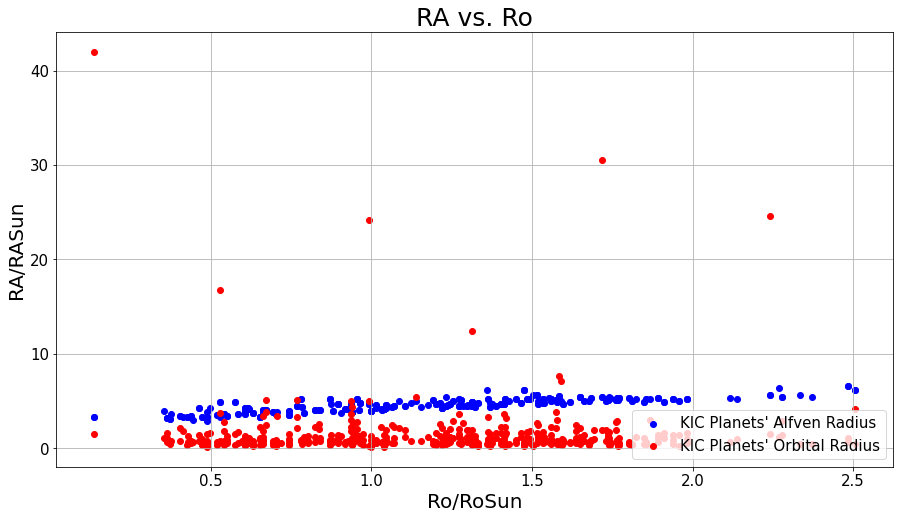

In [44]:
fig3 = plt.figure(figsize=(15,8))
ax3 = fig3.add_subplot(111)
# ax3.plot(x, ra_schrijver(x * ro_sol, r_sol), color='black', label='Schrijver')
ax3.scatter(data['RoAvg'], ra_schrijver(data['RoAvg'], data['Rad_y']), color='#0000FF', label="KIC Planets' Alfven Radius")
ax3.scatter(data['RoAvg'], data['semi_major_axis'] / ra_sol, color='#FF0000', label="KIC Planets' Orbital Radius")
# ax3.scatter(habitable_ro['RoAvg'], alfven[habitable], color='#00FF00', label="Goldilocks Planets")
ax3.set_title("RA vs. Ro",fontsize=25)
ax3.set_xlabel("Ro/RoSun",fontsize=20)
ax3.set_ylabel("RA/RASun",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax3.grid(visible=True)
# ax3.set_xlim([0.0,1.5])
# ax3.set_ylim([0.0,2.5])
ax3.legend(loc=4,fontsize=15)
pass

In [61]:
# 0.1 to 0.5 ME or 0.4 to 0.8 RE
alfven_subterr = alfven_data[(np.fabs(alfven_data['mass'] - 0.3) <= 0.2) | (np.fabs(alfven_data['radius'] - 0.6) <= 0.2)]
# 0.5 to 3.0 ME or 0.8 to 1.6 RE
alfven_terr = alfven_data[(np.fabs(alfven_data['mass'] - 1.75) <= 1.25) | (np.fabs(alfven_data['radius'] - 1.2) <= 0.4)]
# 3.0 to 10. ME or 1.6 to 2.5 RE
alfven_superterr = alfven_data[(np.fabs(alfven_data['mass'] - 6.5) <= 3.5) | (np.fabs(alfven_data['radius'] - 2.05) <= 0.45)]
# > 10. ME or > 2.5 RE
alfven_giant = alfven_data[(alfven_data['mass'] > 10.) | (alfven_data['radius'] > 2.5)]
print([len(alfven_subterr),len(alfven_terr),len(alfven_superterr), len(alfven_giant)])

[26, 25, 7, 4]


In [69]:
# pd.merge(alfven_subterr, habitable, on='# name')
# pd.merge(alfven_terr, habitable, on='# name')
# pd.merge(alfven_superterr, habitable, on='# name')
# pd.merge(alfven_giant, habitable, on='# name')

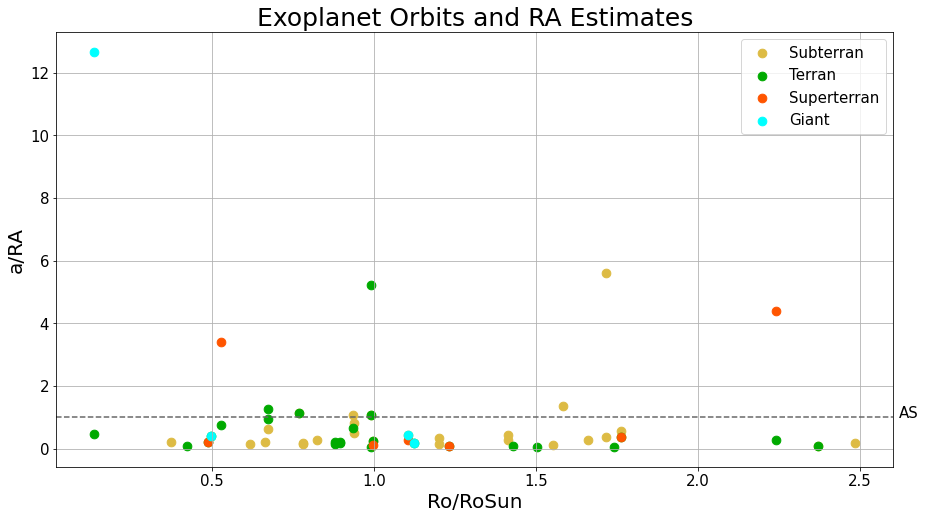

In [73]:
fig4 = plt.figure(figsize=(15,8))
ax4 = fig4.add_subplot(111)
ax4.scatter(alfven_subterr['RoAvg'],alfven_subterr['orbit-alfven'], color='#DDBB44', s=75, label='Subterran')
ax4.scatter(alfven_terr['RoAvg'],alfven_terr['orbit-alfven'], color='#00AA00', s=75, label='Terran')
ax4.scatter(alfven_superterr['RoAvg'],alfven_superterr['orbit-alfven'], color='#FF5500', s=75, label='Superterran')
ax4.scatter(alfven_giant['RoAvg'],alfven_giant['orbit-alfven'], color='#00FFFF', s=75, label='Giant')
# for idx, row in alfven_habitable.iterrows():
#     xpt = row['RoAvg']
#     ypt = row['orbit-alfven']
#     lbl = row['# name']
#     ax2.scatter(xpt, ypt, color='#0000FF', s=250, marker='*')
#     ax2.text(xpt + 0.02, ypt + 0.01, lbl, fontsize=20)
    
ax4.set_title("Exoplanet Orbits and RA Estimates",fontsize=25)
ax4.set_xlabel("Ro/RoSun",fontsize=20)
ax4.set_ylabel("a/RA",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax4.grid(visible=True)
# ax4.set_xlim([0.0,1.5])
# ax4.set_ylim([0.0,2.0])
ax4.legend(loc=1,fontsize=15)
plt.axhline(y = 1.0, xmin = 0.00, xmax = np.max(data['RoAvg']), linestyle='--', color='#666666')
# plt.text(1.52, 0.98, 'AS', fontsize=15)
plt.text(2.62, 0.98, 'AS', fontsize=15)
pass